# Section F: Logistic Regression vs. Bayesian Classifier
## Question 7: Discriminative vs Generative Models

In [23]:
# Generation Process
## Libraries:
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2)
library(reshape2)

## reading data from file
train <- read.csv('Task1E_train.csv')
test <- read.csv('Task1E_test.csv')

C0 <- 1; C1 <- -1 # class labels

In [24]:
dim(train) ##dimensions of train data
dim(test) #dimension of test data

[1] 500   3

[1] 500   3

In [25]:
train.len <- nrow(train)
index.train <- sample(1:train.len, train.len, replace = FALSE)
train.data <- train[index.train,-3] # grab all columns leave out the species (last column)
train.label <- train[index.train,3]
test.data <- test[index.train,-3] # grab all columns leave out the species (last column)
test.label <- test[index.train,3]


### Question 7 (I)
Loading the **Bayesian classifier (BC)** 

In [30]:
###########################    Bayesian Classifier    ########################################
bc <- function(train.d,train.l){

# Class probabilities:
P0 <- sum(train.l==C0)/length(train.l) # total number of samples in class 0 divided by the total nmber of training data
P1 <- sum(train.l==C1)/length(train.l) # or simply 1 - p1.hat

# Class means:
mu0 <- colMeans(train.d[train.l==C0,])
mu1 <- colMeans(train.d[train.l==C1,])

# class covariance matrices:
sigma0 <- var(train.d[train.l==C0,])
sigma1 <- var(train.d[train.l==C1,])

# shared covariance matrix:
sigma <- P0 * sigma0 + P1 * sigma1 

# calculate posteriors for train and test:
px0 <- P0*dmvnorm(x=train.data, mean=mu0, sigma=sigma)
px1 <- P1*dmvnorm(x=train.data, mean=mu1, sigma=sigma)
    
py0 <- P0*dmvnorm(x=test.data, mean=mu0, sigma=sigma)
py1 <- P1*dmvnorm(x=test.data, mean=mu1, sigma=sigma)

# calculate predictions for train and test:
train.predict <- ifelse(px0 > px1, C0, C1)
test.predict <- ifelse(py0 > py1, C0, C1)
    
#missclasified error for train and test
train.error <- sum((train.predict != train.label)/nrow(train.data))*100
test.error <- sum((test.predict != test.label)/nrow(test.data))*100
    
    # returning train and test error
    return(c(train.error,test.error))

    }

Loading the **logistic regression (LR)**

**Step 1:** defining our **sigmoid** function, **auxilary** functions and **error** function.

In [27]:
# Sigmoid function (=p(C1|X))
sigmoid <- function(w, x){
    return(1.0/(1.0+exp(-w%*%t(cbind(1,x)))))    
}

# auxiliary function that predicts class labels
predict <- function(w, X, c0, c1){
    sig <- sigmoid(w, X)
    return(ifelse(sig>0.5, c1,c0))
}
    
# auxiliary function that calculate a cost function
cost <- function (w, X, T, c0){
    sig <- sigmoid(w, X)
    return(sum(ifelse(T==c0, 1-sig, sig)))
}


**Step 2: lr function** initalising weight vector, learning rate, stopping threshold and using SGD to learn the weight vector.

In [28]:
lr <- function(train.d,train.l){
    
    # Initializing parameters
    tau.max <- nrow(train.d) # maximum number of iterations
    eta <- 0.01 # learning rate
    epsilon <- 0.01 # a threshold on the cost (to terminate the process)
    tau <- 1 # iteration counter
    terminate <- FALSE

    ## name/type conversion to make the rest of the code easy to follow
    X <- as.matrix(train.d) # rename just for conviniance
    T <- ifelse(train.l==C0,0,1) # rename just for conviniance

    W <- matrix(,nrow=tau.max, ncol=(ncol(X)+1)) # to be used to store the estimated coefficients
    W[1,] <- runif(ncol(W)) # initial weight values

    # project data using the sigmoid function
    Y <- sigmoid(W[1,],X)

    costs <- data.frame('tau'=1:tau.max)  # to be used to trace the cost in each iteration to comapre with epsilon
    # initial cost for initial set of weights
    costs[1, 'cost'] <- cost(W[1,],X,T, C0)
    
        while(!terminate){
        # check termination criteria:
        terminate <- tau >= tau.max | cost(W[tau,],X,T, C0)<=epsilon

        # shuffle data:
        train.index <- sample(1:nrow(X), nrow(X), replace = FALSE)
        X <- X[train.index,]
        T <- T[train.index]

        # for each datapoint in train:
        for (i in 1:nrow(X)){
            # check termination criteria:
            if (tau >= tau.max | cost(W[tau,],X,T, C0) <=epsilon) {terminate<-TRUE;break}

            Y <- sigmoid(W[tau,],X)

            # Update the weights
            W[(tau+1),] <- W[tau,] - eta * (Y[i]-T[i]) * cbind(1, t(X[i,]))

            # record the cost:
            costs[(tau+1), 'cost'] <- cost(W[tau,],X,T, C0)

            # update the counter:
            tau <- tau + 1

            # decrease learning rate:
#             eta = eta * 0.999
        }
    }
    
        # Storing the predicitons in variables
        lr.train <- predict(W[tau,], train.data, C0, C1)
        lr.test <- predict(W[tau,],test.data,C0,C1)
        
    
    # calculating missclassified train and test error:
    train.error <- sum(lr.train != train.label)/nrow(train.data) * 100
    test.error <- sum(lr.test != test.label)/nrow(test.data) * 100
    
    # returning missclassified train and test error
    return (c(train.error,test.error))
}

### Question 7 (II)
In a “for loop”, increasing the size of training set by 5 data points every time to train a BC and a LR model, and calculating their training and testing errors until all training data points are used.

In [31]:
### main loop for calculating misclassified train and test error 
### of model trained on batches of size incremented by 5 each time 
batch = 1      # counter

# dataframes to store train and test errors of both the models
bc_error <- data.frame('Batch_Size'=seq(5,nrow(train.data),5))
lr_error <- data.frame('Batch_Size'=seq(5,nrow(train.data),5))

# iteration of 5 more data points every time
for (i in seq(5,train.len,5)){
    
    # train data of size i where is a multiple of 5
    train.d = train.data[1:i,]
    train.l = train.label[1:i]
    
    # function call to get train and test error of models trained on data of size i
    bc_e <- bc(train.d,train.l)
    lr_e <- lr(train.d,train.l)
    
    # store train and test error of Bayesian Classifier in dataframe for bc
    bc_error[batch,'bc_train_error'] = bc_e[1]
    bc_error[batch,'bc_test_error'] = bc_e[2]

    # store train and test error of Logistic Regression in dataframe for lr
    lr_error[batch,'lr_train_error'] = lr_e[1]
    lr_error[batch,'lr_test_error'] = lr_e[2]    
    
    batch = batch + 1      # update counter
}

In [34]:
# merging dataframes for visualisation
errors = merge(bc_error,lr_error, by = 'Batch_Size')

Ploting the training errors of the BC and LR models (with different colors) versus the size of the training set.

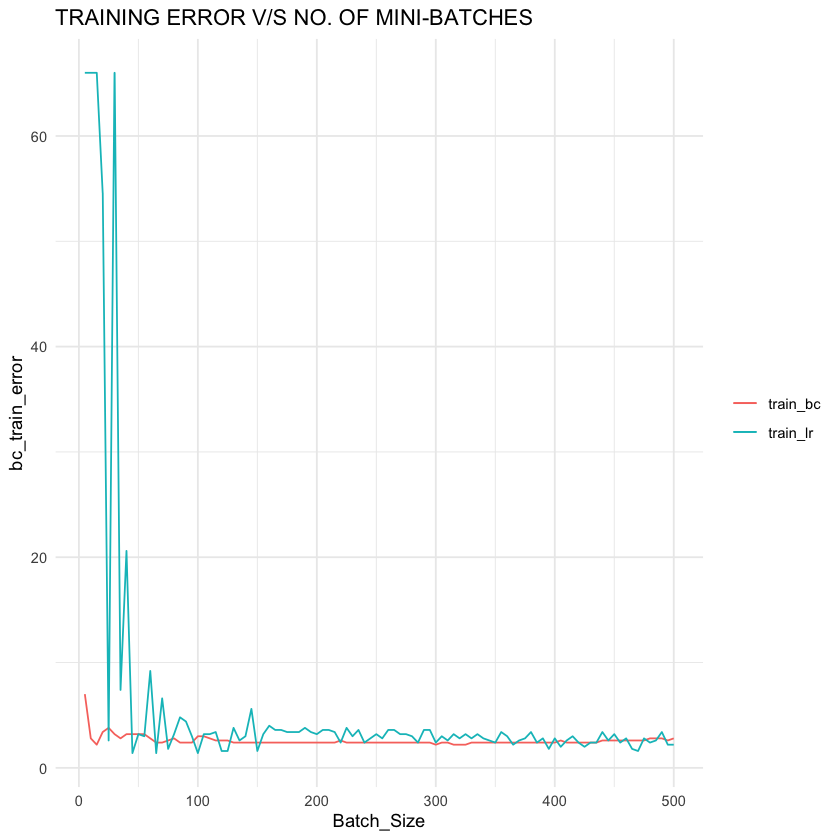

In [35]:
# plot misclassification error of both models for train data set 
ggplot(data=errors) + geom_line(aes(x=Batch_Size, y=bc_train_error, color='train_bc')) + geom_line(aes(x=Batch_Size, y=lr_train_error, color='train_lr')) +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
       ggtitle("TRAINING ERROR V/S NO. OF MINI-BATCHES")

Ploting the testing errors of the BC and LR models(with different colors) versus the size of the training set.

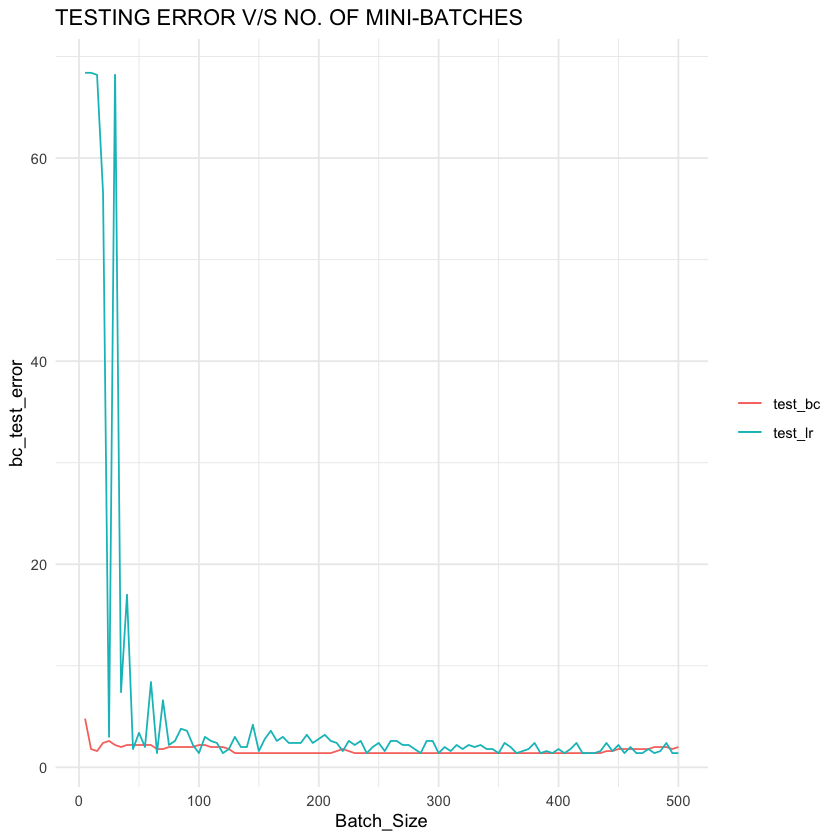

In [36]:
# plot misclassification error of both models for test data set 
ggplot(data=errors) + geom_line(aes(x=Batch_Size, y=bc_test_error, color='test_bc')) + geom_line(aes(x=Batch_Size, y=lr_test_error, color='test_lr')) +
       scale_color_discrete(guide = guide_legend(title = NULL)) + theme_minimal() +
       ggtitle("TESTING ERROR V/S NO. OF MINI-BATCHES")

### Question 7 (III)
i) Both classifiers models have higher error for small training data, which tends to decrease when the number of training data points is increases. For Logistic regression, the change is quite big as the train and test error decrease to a very low value with increase in batch size. Whereas, in case of BC classifier model, the effect of size is minimal.   

ii) Bayesian classifier (BC) is best suited when the training set is small whereas Logestic Regression classifier model are good when training data is big.

From the Graphs above we can say that for small training datasets, Bayesian classifier (BC) gives relatively less train and test error. So, we can say that Bayesian classifier (BC) is best suited when the training set is small.
Whereas, size of training data has high impact on Logestic Regression classifier model, and the train and test error rate decreses with with increase in size. This means that this model can result in better predictions when trained on big datasets.

Bayesian classifier (BC) is a probabilistic generative model whereas Logestic Regression classifier is a probabilistic discriminative model. Generative models like BC are more complex as they require more parameters lile mu and sigma for prediction. Therefore, LR model is a better choice in this case. 